In [47]:
import logging
import hashlib
import time
import json
import signal
import pickle
from pathlib import Path
from datetime import datetime
from epdlib import Layout

In [2]:
logger = logging.getLogger(__name__)

In [3]:
def strict_enforce(*types):
    """strictly enforce type compliance within classes
    
    Usage:
        @strict_enforce(type1, type2, (type3, type4))
        def foo(val1, val2, val3):
            ...
    """
    def decorator(f):
        def new_f(self, *args, **kwds):
            #we need to convert args into something mutable   
            newargs = []        
            for (a, t) in zip(args, types):
                if not isinstance(a, t):
                    raise TypeError(f'"{a}" is not type {t}')
            return f(self, *args, **kwds)
        return new_f
    return decorator

In [4]:
class TimeOutException(Exception):
    pass

In [209]:
class Plugin:
    def __repr__(self):
        return f'Plugin({self.name})'
    
    def __str__(self):
        return str(self.name)

    def __getstate__(self):
        logging.debug('object is being pickled')
        state = self.__dict__.copy()
        state['_update_function'] = None
        
        return state

    def __setstate(self, d):
        logging.debug('object is being unpickled')
        self.__dict__.update(d)
        self._update_function = None
        
    
    def __init__(self, resolution, 
                 name=None,
                 layout={},
                 update_function=None,
                 max_priority = 2**15,
                 refresh_rate=60,
                 min_display_time=30,
                 config={},
                 cache=None,
                 force_onebit=False,
                 screen_mode='1',
                 plugin_timeout=20,
                 plugin_debug=False,
                 plugin_debug_root=None,
                 max_debug_files = 10,
                 **kwargs):
        
        '''Create a plugin object that provides consistent methods for providing an image and querying
        various services
        
        Properties:
            hash('str'): unique identifier for this plugin in its current state (used for checking for changes)
            image(PIL image): image generated for this plugin
            data(dict): data returned by this plugin to be used in the Layout
            priority(int): current priority for this plugin (lower numbers are more important in display loop)
            last_ask(float): time in seconds since this plugin was last asked for an update -- used for throttling
        
        Args:
            resolution(`tuple` of `int`): resolution of the epd or similar screen: (Length, Width)
            name(`str`): human readable name of the function for logging and reference
            layout(`dict`): epdlib.Layout.layout dictionary that describes screen layout
            update_function(func): function that returns plugin status, data and priority a
                update_function must accept (self, *args, **kwargs) and must return
                a tuple of (is_updated(bool), data(dict), priority(int))
            max_priority(`int`): maximum priority for this module values approaching 0 have highest
                priority, values < 0 are inactive
            refresh_rate(`int`): minimum time in seconds between requests for pulling an update
            min_display_time(`int`): minimum time in seconds plugin should be allowed to display in the loop
            config(`dict`): any kwargs that update function requires
            cache(`CacheFiles` obj): object that can be used for downloading remote files and caching
            force_onebit(`bool`): force layouts to 1bit mode
            plugin_timeout(`int`): time in seconds to wait for plugin function to return (default: 20)
            plugin_debug(`bool`): when True, activate additional plugin debugging
            plugin_debug_root(`Path` or `str`): path to store plugin debugging output (images, meta data, etc.);
                a directory will be created for each plugin within the provided path
            max_debug_files(`int`): max number of debugging files to store
            kwargs(): any additional kwargs will be ignored
            '''
        
        self.name = name
        self.plugin_debug = plugin_debug
        self.plugin_debug_root = plugin_debug_root
        self.max_debug_files = max_debug_files
        self.priority = 2**15
        self.resolution = resolution
        self.force_onebit = force_onebit
        self.screen_mode = screen_mode
        self.layout = layout
        self.config = config
        self.cache = cache
        self.update_function = update_function
        self.refresh_rate = refresh_rate
        self.min_display_time = min_display_time
        self._last_ask = 0
        self.data = {}
        self.image = None
        self.max_priority = max_priority
        self.hash = self._generate_hash()
        self.plugin_timeout = plugin_timeout
        
    
        
    
    def _generate_hash(self):
        '''generate a hash based on the self.name and the current time
            This is updated whenever self.data is updated and can be checked as a 
            proxy for "new data"'''
        my_hash = hashlib.sha1()
        my_hash.update(str(time.time()).encode('utf-8')+str(self.name).encode('utf-8'))
        return my_hash.hexdigest()[:10]        
    
    def _is_ready(self):
        '''simple throttle of update requests
            Checks time between current request (monotonic) and self._last_ask and compares to 
            self.refresh_rate
        
        Returns:
            `bool`: True if cooldown period has expired, false otherwise'''        
        if time.monotonic() - self.last_ask > self.refresh_rate:
            self._last_ask = time.monotonic()
            return True
        else:
            logger.debug(f'throttling in effect {self.refresh_rate - (time.monotonic() - self._last_ask):.1f} seconds left in cooldown period')
            return False

    def _alarm_handler(self, signum, frame):
        raise TimeOutException(f'Plugin "{self.name}" update function timed-out after a max of {self.plugin_timeout} seconds')
    
    
    def update(self, force=False, *args, **kwargs):
        '''request an update of the plugin data
            requests are throttled if they occur sooner than the cool-down period
            defined by self.refresh_rate
            
            Returns:
                self.hash(hash of time and self.name)
            
            calls self.update_function(*args, **kwargs):
                self.update_function returns: (`tuple` of `bool`, `dict`, `int`): 
                    bool(true when plugin is updated) 
                    dict(data returned from plugin update_function to be passed into a layout)
                    int(priority of this module; values approaching 0 are highest, negative
                        values indicate plugin is inactive)

            
            Set here:
                self.data
                self.layout_obj.update_contents(self.data)
                self.hash'''        
        if self._is_ready() or force:
            logging.info(f'starting update - timeout: {self.plugin_timeout} sec')
            signal.signal(signal.SIGALRM, self._alarm_handler)
            signal.alarm(self.plugin_timeout)
            try:
                is_updated, data, priority = self.update_function(*args, **kwargs)
            except TimeOutException as e:
                logging.warning(e)
            else:
                if data != self.data:
                    self.data = data
                    self.layout_obj.update_contents(data)
                    self.image = self.layout_obj.concat()
                    self.hash = self._generate_hash()
                else:
                    logging.debug('data has not changed since last update; plugin will not update')
                self.priority = priority

                if self.plugin_debug:
                    self.write_debug(is_updated=is_updated, 
                                    data=data, 
                                    priority=priority,
                                    img=self.image)
                    self.rotate_debug()
                
            finally:
                signal.alarm(0)        
        else:
            pass
        
        return self.hash
    
    def force_update(self, *args, **kwargs):
        '''force an immediate update'''
        logging.info(f'forced update of plugin: {self.name}')
#         is_updated, data, priority = self.update_function(*args, **kwargs)
#         self.data = data
#         self.layout_obj.update_contents(data)
#         self.image = self.layout_obj.concat()
#         self.hash = self._generate_hash()
#         self.priority = priority
#         logging.debug(f'Data: {self.data}')
        
        return self.update(force=True, *args, **kwargs)       
    

    def write_debug(self, is_updated=None, data={}, priority=None, img=None):
        '''write debugging output

        Args: 
            is_updated(`bool`): True when plugin is successfully updated
            data(`dict`): data provided by the update_function
            priority(`int`): plugin current priority level
            img(PIL image): pil image object
        '''
        timestamp = datetime.now().strftime('%y%m%d-%H.%M.%S')
        filename = f'{timestamp}'

        meta_file = self.plugin_debug_output/f'{filename}.meta'
        img_file = self.plugin_debug_output/f'{filename}.png'
        pkl_file = self.plugin_debug_output/f'{filename}.pkl'

        meta_data = {
            'timestamp': timestamp,
            'is_updated': is_updated,
            'priority': priority,
            'data': data,
            'hash': self.hash,
            'layout': self.layout,
        }

        try:
            img.save(img_file)
        except Exception as e:
            logging.warning(f'{e}: failed to write image file')
        
        try:
            with meta_file.open(mode='w') as file:
                json.dump(meta_data, file, indent=4)
        except (IOError, OSError) as e:
            logging.error(f'{e}: error while writing ')

        try:
            with open(pkl_file, 'wb') as file:
                pickle.dump(self, file)
        except (IOError, OSError, pickle.PicklingError) as e:
            logging.error(f'{e}: failed to write plugin pickle')

    def rotate_debug(self):
        '''remove the oldest plugging debug files keeping at most `max_plugin_files` for each type of file'''
        try:

            files = sorted(self.plugin_debug_output.iterdir())
            
            file_name_set = {file.stem for file in files if file.is_file()}
            del_list = sorted(file_name_set)
            
            del_list.reverse()
            
            del_list = del_list[self.max_debug_files:]
            
            for file in files:
                if file.is_file() and file.stem in del_list:
                    logging.debug(f'deleting debug file: {file}')
                    file.unlink()

        
        except (FileNotFoundError, PermissionError, OSError) as e:
            logging.debug(f'{e}: could not rotate debug files')

        
        
    
    @property
    def plugin_timeout(self):
        '''timeout in seconds for plugin to respond with data'''
        return self._plugin_timeout
    
    @plugin_timeout.setter
    def plugin_timeout(self, timeout):
        if not isinstance(timeout, int):
            raise ValueError('timeouts must be integers')
        if timeout < 1:
            raise ValueError('timeouts must be integer values > 0')
        self._plugin_timeout = timeout
    
    @property
    def cache(self):
        '''CacheFiles object used for caching remote files used by plugins
        cache(`CacheFiles` obj)'''
        return self._cache
    
    @cache.setter
    def cache(self, cache):
        self._cache = cache
    
    
    @property
    def last_ask(self):
        return self._last_ask
    
    @last_ask.setter
    def last_ask(self, last_ask):
        self._last_ask = last_ask
    
    @staticmethod
    def _null_update():
        return None
    
        
    @property
    def resolution(self):
        return self._resolution
    
    @resolution.setter
    @strict_enforce((list, tuple))
    def resolution(self, resolution):
        self._resolution = resolution
    
    @property
    def update_function(self):
        '''update function provided by the plugin module
        
        The update_function is called by the update method to provide status and data for 
        the Plugin.
        
        Args:
            function(function): function that accepts self, *args, **kwargs
            
        Returns:
            tuple of is_updated(bool), data(dict), priority(int)'''
        return self._update_function
    
    @update_function.setter
    def update_function(self, function):
        if not function:
            self._update_function = self._null_update
        else:
            self._update_function = function.__get__(self)
    
    @property
    def force_onebit(self):
        '''resolution of attached screen that will be used for output
         resolution(`tuple` of `int`)'''        
        return self._force_onebit
    
    @force_onebit.setter
    @strict_enforce(bool)
    def force_onebit(self, force_onebit):
        self._force_onebit = force_onebit
    
            
    @property
    def layout(self):
        '''epdlib.Layout.layout dictionary used for configuring text and image blocks
            layout(`dict`)'''        
        return self.layout_obj.layout
    
    @layout.setter
    def layout(self, layout):
        # convert blocks to RGB when possible
        for block, values in layout.items():
            if values.get('rgb_support', False) and self.screen_mode == 'RGB' and not self.force_onebit:
                logging.debug(f'{block} supports RGB')
                values['mode'] = 'RGB'
        
        self.layout_obj = Layout(resolution=self.resolution, 
                                 layout=layout,
                                 force_onebit=self.force_onebit,
                                 mode=self.screen_mode)

    @property
    def plugin_debug_root(self):
        return self._plugin_debug_root

    @plugin_debug_root.setter
    def plugin_debug_root(self, path):
        try:
            self._plugin_debug_root = Path(path)
            self.plugin_debug_output = self._plugin_debug_root/self.name.replace(' ', '_')
        except (OSError, TypeError, ValueError) as e:
            if self.plugin_debug:
                logging.error(f'{e}: could not set debug output directory; switching off extended debugging')
            self._plugin_debug_root = None
            self.plugin_debug_output = None
            self.plugin_debug = False

        if self.plugin_debug and not self.plugin_debug_output.exists():
            try:
                self.plugin_debug_output.mkdir(parents=True, exist_ok=True)
            except (OSError, FileNotFoundError) as e:
                if self.debug:
                    logging.error(f'{e}, could not create output directory; switch off extended debugging')
                self.plugin_debug = False

plugin sleeping for 0 seconds to simulate delayed response


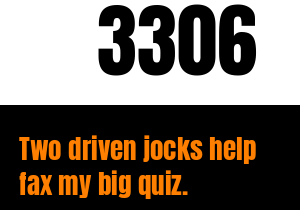

In [202]:
# # import pickle

# logging.root.setLevel('WARNING')
# p = main(True, 1)
# p.name = 'Bogus Plugin'
# p.plugin_debug = True
# p.plugin_debug_root = '/tmp/PaperPi-Debugging/'
# p.plugin_timeout = 8

# p.update()

# p.image

# # with open("foo.pkl", 'wb') as f:
# #     pickle.dump(p, f)

In [208]:
# p.update()

INFO:root:starting update - timeout: 8 sec


plugin sleeping for 0 seconds to simulate delayed response


'ed06438a35'

In [205]:
def main(simple=False, delay=10):
    '''demo of Plugin data type'''
    from random import randint, choice
    from IPython.display import display
    from time import sleep
    bogus_layout = {
        'number': {
            'type': 'TextBlock',
            'image': None,
            'max_lines': 1,
            'width': 1,
            'height': .5,
            'abs_coordinates': (0, 0),
            'rand': True,
            'font': '../fonts/Anton/Anton-Regular.ttf',
        },
        'text': {
            'abs_coordinates': (0, None),
            'relative': ('text', 'number'),
            'type': 'TextBlock',
            'image': None,
            'max_lines': 3,
            'height': .5,
            'width': 1,
            'rand': True,
            'font': '../fonts/Anton/Anton-Regular.ttf',
            'fill': 'ORANGE',
            'bkground': 'BLACK',
            'rgb_support': True
        }
    }

    # update_function that is added to the plugin as the method self.update_function
    def bogus_plugin(self):        
        text = [
            'The quick brown fox jumps over the lazy dog.',
            'Jackdaws love my big sphinx of quartz.',
            'Two driven jocks help fax my big quiz.',
            'By Jove, my quick study of lexicography won a prize!',
            'How vexingly quick daft zebras jump!'
        ]
        data = {'number': str(randint(99,9999)), 'text': choice(text)}
        priority = self.max_priority
        is_updated = True
        
        sleep_time = randint(0, delay)
        print(f'plugin sleeping for {sleep_time} seconds to simulate delayed response')
        sleep(sleep_time)

        return (is_updated, data, priority) 


    p = Plugin(resolution=(300, 210), 
               refresh_rate=2, 
               max_priority=1, 
               update_function=bogus_plugin, 
               layout=bogus_layout,
               screen_mode='RGB',
               plugin_timeout=5)

    if simple:
        return p
    # Plugin.update_function = bogus_plugin

    logger.root.setLevel('INFO')
    print('this demo is best run from inside jupyter notebook')
    p.force_update()
    print('this is a forced update')
    display(p.image)
    p.force_update()
    print('this is a forced update')
    display(p.image)

    for i in range(5):
        colors = ['RED', 'ORANGE', 'YELLOW', 'GREEN', 'BLUE', 'BLACK', 'WHITE']
        fill = choice(colors)
        colors.remove(fill)
        bkground = choice(colors)
        p.layout_obj.update_block_props(block='text', props={'bkground': bkground, 'fill': fill})        
        print('trying to update plugin')
        p.force_update()
        print('displaying image')
        display(p.image)
#         print('sleep for 1 second')
        sleep(1)
    return p

In [206]:
if __name__ == '__main__':
    p = main()

INFO:root:forced update of plugin: None
INFO:root:starting update - timeout: 5 sec


this demo is best run from inside jupyter notebook
plugin sleeping for 5 seconds to simulate delayed response


this is a forced update


None

INFO:root:forced update of plugin: None
INFO:root:starting update - timeout: 5 sec


plugin sleeping for 6 seconds to simulate delayed response


KeyboardInterrupt: 